In [110]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from pathlib import Path
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

sys.path.append(str(Path(os.getcwd()).parent))
from data_utilities import find_outliers, convert_age_from_days_to_years, extractqrcode, draw_age_distribution, calculate_code_age_distribution

### Total no. of artifacts in dataset

In [111]:
DATASET_NAME = 'dataset-depthmap-Test-2021-08-31-13-59-22'
DATASET_PATH = Path(f'/mnt/datasets/{DATASET_NAME}')

In [118]:
SAMPLE_PICKLE_PATH = 'scans/048f26e0-073e-11ec-abef-43e532deb910/100/pc_0490ad80-073e-11ec-abef-4f801ac83047_13:18:44_100_1.0.p'
!ls /mnt/datasets/{DATASET_NAME}/{SAMPLE_PICKLE_PATH}

/mnt/datasets/dataset-depthmap-Test-2021-08-31-13-59-22/scans/048f26e0-073e-11ec-abef-43e532deb910/100/pc_0490ad80-073e-11ec-abef-4f801ac83047_13:18:44_100_1.0.p


In [114]:
!du /mnt/datasets/{DATASET_NAME} -sh --apparent-size

837M	/mnt/datasets/dataset-depthmap-Test-2021-08-31-13-59-22


In [153]:
# Check resolution of depthmap
for fpath_pickle in tqdm(DATASET_PATH.glob('**/*.p')):
    depthmap, targets = pickle.load(open(fpath_pickle, "rb"))
    assert depthmap.shape == (240, 180, 1), fpath_pickle

5037it [00:41, 122.54it/s]


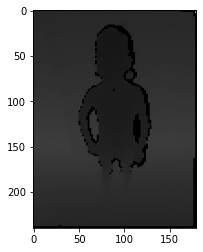

In [119]:
paths  = DATASET_PATH / SAMPLE_PICKLE_PATH
depthmap, targets = pickle.load(open(paths, "rb"))
_ = plt.imshow(np.squeeze(depthmap), cmap='gray')
plt.show()

In [120]:
print("targets: ", targets)
print("depthmap.shape: ", depthmap.shape)

targets:  {'file_path': '1630072337440/c2a65708-1f75-471a-95a5-f9a3b93b1335', 'timestamp': '13:18:44', 'scan_id': '0490ad80-073e-11ec-abef-4f801ac83047', 'scan_step': 100, 'scan_version': 'v0.9', 'height': 84.5, 'weight': 9.95, 'muac': 13.3, 'order_number': 1.0, 'format': 'depth', 'device_model': 'HUAWEI VOG-L29', 'person_id': '048f26e0-073e-11ec-abef-43e532deb910', 'age': 979, 'sex': 'male', 'device_pose': [-0.5191621171972739, -0.8538938613176806, -0.03655091888347257, 0.0, -0.0106324707443454, -0.03630986751662386, 0.9992840157266583, 0.0, -0.8546096457641437, 0.5191790318617532, 0.009771706195846594, 0.0, -0.34911937, 0.29918483, -0.13677283, 1.0], 'raw_header': '240x180_0.001_7_-0.35615167_0.60685265_0.6255485_-0.3370088_0.34911937_-0.29918483_0.13677283', 'angle': -31.277198675360417}
depthmap.shape:  (240, 180, 1)


In [121]:
!head /mnt/datasets/{DATASET_NAME}/labels.csv

scan_id,scan_step,scan_version,device_model,height,weight,muac,order_number,timestamp,timestamp,person_id,age,sex
d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,2.0,2021-08-27 09:54:17.847626,23:46:17,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,4.0,2021-08-27 09:54:17.956982,23:46:29,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,6.0,2021-08-27 09:54:18.081981,23:46:34,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,8.0,2021-08-27 09:54:18.222609,00:01:07,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,10.0,2021-08-27 09:54:18.347636,00:01:10,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3

In [122]:
artifacts = pd.read_csv(DATASET_PATH / 'labels.csv')
print("Total no. of artifacts:", len(artifacts))
artifacts.head()

Total no. of artifacts: 5038


,scan_id,scan_step,scan_version,device_model,height,weight,muac,order_number,timestamp,timestamp.1,person_id,age,sex
0,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,2.0,2021-08-27 09:54:17.847626,23:46:17,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
1,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,4.0,2021-08-27 09:54:17.956982,23:46:29,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
2,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,6.0,2021-08-27 09:54:18.081981,23:46:34,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
3,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,8.0,2021-08-27 09:54:18.222609,00:01:07,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male
4,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,10.0,2021-08-27 09:54:18.347636,00:01:10,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male


In [123]:
#adding the Years column into dataframe
artifacts['Years'] = artifacts.apply(convert_age_from_days_to_years, axis=1)
artifacts.head()

,scan_id,scan_step,scan_version,device_model,height,weight,muac,order_number,timestamp,timestamp.1,person_id,age,sex,Years
0,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,2.0,2021-08-27 09:54:17.847626,23:46:17,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male,3
1,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,4.0,2021-08-27 09:54:17.956982,23:46:29,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male,3
2,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,6.0,2021-08-27 09:54:18.081981,23:46:34,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male,3
3,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,8.0,2021-08-27 09:54:18.222609,00:01:07,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male,3
4,d6b66880-071c-11ec-abef-cbac92b5efb6,102,v0.9,HUAWEI VOG-L29,93.5,11.3,13.1,10.0,2021-08-27 09:54:18.347636,00:01:10,d6aec760-071c-11ec-abef-5fee6f3a36ac,1446,male,3


### Total no. of children in the dataset

In [124]:
print("Total no. of artifacts:", len(artifacts))
unique_scan_ids = artifacts.drop_duplicates(subset='scan_id', keep='first')
print("Total no. of unique scan ids:", len(unique_scan_ids))
unique_person_ids = artifacts.drop_duplicates(subset='person_id', keep='first')
print("Total no. of unique person ids:", len(unique_person_ids))

Total no. of artifacts: 5038
Total no. of unique scan ids: 298
Total no. of unique person ids: 73


HUAWEI VOG-L29    5038
Name: device_model, dtype: int64


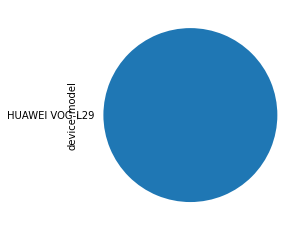

In [125]:
print(artifacts['device_model'].value_counts())
_ = artifacts['device_model'].value_counts().plot(kind='pie')

v0.9      4661
v1.0.2     220
v0.8       157
Name: scan_version, dtype: int64


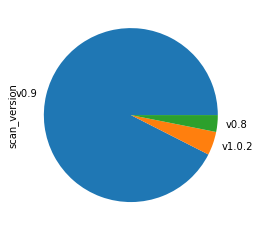

In [126]:
print(artifacts['scan_version'].value_counts())
_ = artifacts['scan_version'].value_counts().plot(kind='pie')

2021-08-31 14:10:20,666 - INFO - 0     5
1    13
2    15
3    18
4    22
Name: Years, dtype: int64 - /mnt/batch/tasks/shared/LS_root/mounts/clusters/mhinsche1/code/Users/mhinsche/cgm-ml/cgmml/data_utils/dataset_EDA/data_utilities.py: line 31


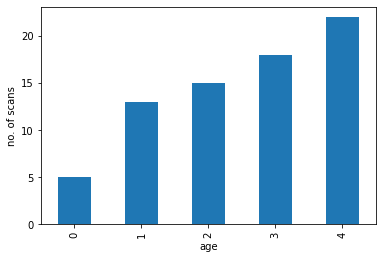

In [127]:
draw_age_distribution(unique_person_ids)

2021-08-31 14:10:22,147 - INFO - 0     15
1     43
2     51
3    105
4     84
Name: Years, dtype: int64 - /mnt/batch/tasks/shared/LS_root/mounts/clusters/mhinsche1/code/Users/mhinsche/cgm-ml/cgmml/data_utils/dataset_EDA/data_utilities.py: line 31


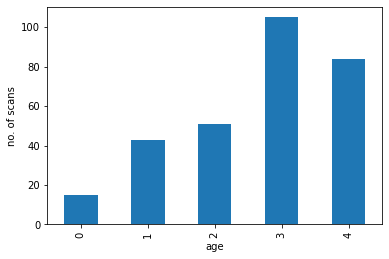

In [128]:
draw_age_distribution(unique_scan_ids)

101    2498
100     837
102     828
201     605
202     135
200     135
Name: scan_step, dtype: int64


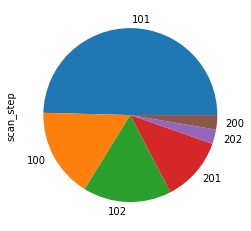

In [129]:
## keys for different scan type and their distribution in dataset
"- 100 - standing front scan",
"- 101 - standing 360 scan",
"- 102 - standing back scan",
"- 200 - lying front scan",
"- 201 - lying side scan",
"- 202 - lying back scan"
print(artifacts['scan_step'].value_counts())
_ = artifacts['scan_step'].value_counts().plot(kind='pie')

In [130]:
scan_type_colname = 'scan_step' # for other datasets this can be "key"
calculate_code_age_distribution(artifacts, scan_type_colname)

2021-08-31 14:10:26,606 - INFO - scan_step - /mnt/batch/tasks/shared/LS_root/mounts/clusters/mhinsche1/code/Users/mhinsche/cgm-ml/cgmml/data_utils/dataset_EDA/data_utilities.py: line 52


,0,1,2,3,4
codes,,,,,
102,0,54,144,369,261
101,0,130,494,1014,860
100,0,63,180,324,270
201,164,415,26,0,0
202,45,81,9,0,0
200,45,81,9,0,0


In [131]:
calculate_code_age_distribution(unique_scan_ids, scan_type_colname)

2021-08-31 14:10:27,614 - INFO - scan_step - /mnt/batch/tasks/shared/LS_root/mounts/clusters/mhinsche1/code/Users/mhinsche/cgm-ml/cgmml/data_utils/dataset_EDA/data_utilities.py: line 52


,0,1,2,3,4
codes,,,,,
102,0,5,16,35,28
101,0,5,16,35,28
100,0,6,16,35,28
201,5,9,1,0,0
202,5,9,1,0,0
200,5,9,1,0,0


### Distribution of height, weight and age against each other

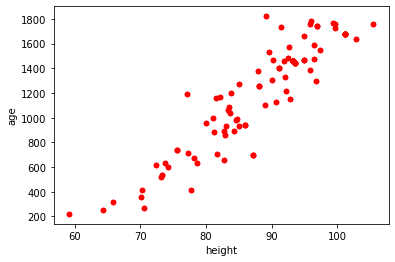

In [132]:
#distribution of height against age
height_vs_age = unique_scan_ids.plot.scatter(x='height', y='age', c='red')


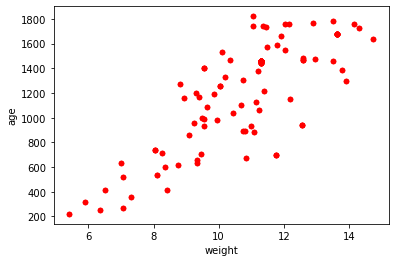

In [133]:
#distribution of weight against age
weight_vs_age = unique_scan_ids.plot.scatter(x='weight', y='age', c='red')

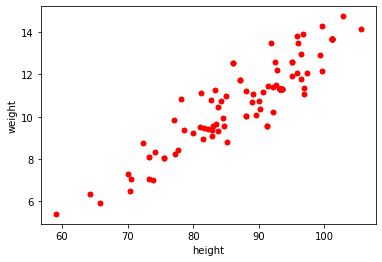

In [134]:
## distribution of height against weight
weight_vs_height = unique_scan_ids.plot.scatter(x='height', y='weight', c='red')

## Analyze outliers: 1) age, 2) weight, 3) height, 4) pixel values

In [135]:
artifacts.describe()

,scan_step,height,weight,muac,order_number,age,Years
count,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000,5038.000000
mean,118.366217,87.547916,10.655568,13.573561,15.206034,1176.636562,2.626638
std,37.893059,9.358740,2.023907,0.918990,17.043930,435.860256,1.189984
min,100.000000,59.100000,5.400000,11.500000,1.000000,220.000000,0.000000
25%,101.000000,82.200000,9.350000,12.900000,5.000000,884.000000,2.000000
50%,101.000000,90.000000,11.100000,13.500000,9.000000,1297.000000,3.000000
75%,102.000000,93.425000,11.750000,14.100000,20.000000,1464.000000,4.000000
max,202.000000,105.500000,14.750000,16.100000,130.000000,1822.000000,4.000000


In [136]:
unique_scan_ids.describe()

,scan_step,height,weight,muac,order_number,age,Years
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,116.097315,87.970805,10.753188,13.547315,1.033557,1201.859060,2.671141
std,35.876527,9.397853,1.992143,0.935968,0.180389,426.309131,1.174608
min,100.000000,59.100000,5.400000,11.500000,1.000000,220.000000,0.000000
25%,100.000000,82.700000,9.500000,12.900000,1.000000,896.000000,2.000000
50%,101.000000,90.600000,11.250000,13.400000,1.000000,1333.000000,3.000000
75%,102.000000,93.500000,11.875000,14.100000,1.000000,1470.000000,4.000000
max,202.000000,105.500000,14.750000,16.100000,2.000000,1822.000000,4.000000


### 1) Check age

##### Check age < 6 months or  > 6 years

In [137]:
def find_outliers(df: pd.DataFrame, column: str, condition: str, data_id_name: str) -> list:
    combined_condition = '@df.' + column + condition
    print(f'Running the following query: {combined_condition}')
    outlier_artifacts = df.query(combined_condition)
    unique_outliers = outlier_artifacts.drop_duplicates(subset=data_id_name, keep='first')
    outliers = unique_outliers[data_id_name].tolist()
    print(f'No. of outliers: {len(outliers)}')
    return outliers

In [138]:
find_outliers(artifacts, 'age', '<365/2', data_id_name='person_id')

Running the following query: @df.age<365/2
No. of outliers: 0


[]

In [139]:
find_outliers(artifacts, 'age', '<365/2', data_id_name='scan_id')

Running the following query: @df.age<365/2
No. of outliers: 0


[]

In [140]:
find_outliers(artifacts, 'age', '>365*6', data_id_name='scan_id')

Running the following query: @df.age>365*6
No. of outliers: 0


[]

### 2) Check weight

In [141]:
find_outliers(artifacts, 'weight', '<5.0', data_id_name='scan_id')

Running the following query: @df.weight<5.0
No. of outliers: 0


[]

In [142]:
find_outliers(artifacts, 'weight', '>30.0', data_id_name='scan_id')

Running the following query: @df.weight>30.0
No. of outliers: 0


[]

### 3) Check height

In [143]:
find_outliers(artifacts, 'height', '<40.0', data_id_name='scan_id')

Running the following query: @df.height<40.0
No. of outliers: 0


[]

In [144]:
find_outliers(artifacts, 'height', '>150.0', data_id_name='scan_id')

Running the following query: @df.height>150.0
No. of outliers: 0


[]